In [ ]:
#https://gym-trading-env.readthedocs.io/en/latest/rl_tutorial.html
#https://medium.com/@sthanikamsanthosh1994/custom-gym-environment-stock-trading-for-reinforcement-learning-stable-baseline3-629a489d462d

### Understand the action space
Positions
I have seen many environments that consider actions such as BUY, SELL. In my experience, it is a mistake to consider a reinforcement learning agent in the same way as a trader. Because, behind a trade, what really matter is the : position reached. In the environment, we label each position by a number : (example with pair BTC/USD)

1 : All of our portfolio is converted into BTC. (=BUY ALL)

0 : All of our portfolio is converted into USD. (=SELL ALL)

Now, we can imagine half position and other variants :

0.5 : 50% in BTC & 50% in USD

Even : 0.1 : 10% in BTC & 90% in USD ….

# Trading Bot

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#https://www.youtube.com/watch?v=SMZfgeHFFcA
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
#from network import DeepQNetwork
#from replay_memory import ReplayBuffer
#tf.get_logger().setLevel('ERROR')

import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import datetime

In [4]:
#from agent import Agent
#import gym 
from env.environment import *
from env.portfolio import *
from utils.utils import *
from agent.agent import *



In [5]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [6]:
# --------------------------------------open data -------------------------------------------------------
# Available in the github repo : examples/data/BTC_USD-Hourly.csv
#url = "https://raw.githubusercontent.com/ClementPerroud/Gym-Trading-Env/main/examples/data/BTC_USD-Hourly.csv"
#df_training = pd.read_csv(url, parse_dates=["date"], index_col= "date")
#df_file = pd.read_csv("./data/BTC_USD-Hourly.csv")
df_file = pd.read_csv("./get_data/Assets/AAPL_data_1d.csv",index_col=False)

In [7]:
#df_file = pd.read_csv("./data/AAL_data.csv")
df_file.sort_index(inplace= True)

In [8]:
df_file.dropna(inplace= True)
df_file.drop_duplicates(inplace=True)

In [9]:
df_file.shape

(3539, 9)

In [10]:
# Transform string date to datetime format
df_file['Date']=df_file['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())

In [11]:
df_file['Date']=pd.to_datetime(df_file['Date'])

In [12]:
df_training=df_file.copy()

In [13]:
# Raname columns from Upper case to lower case

In [14]:
column_list=df_training.columns.to_list()

In [15]:
df_training.columns=[str.lower(x) for x in column_list]

In [16]:
df_training.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume',
       'dividends', 'stock splits'],
      dtype='object')

In [17]:
df_training

,date,open,high,low,close,adj close,volume,dividends,stock splits
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.479000,493729600.0,0.0,0.0
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490200,601904800.0,0.0,0.0
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000.0,0.0,0.0
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375156,477131200.0,0.0,0.0
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3534,2024-01-19,189.330002,191.949997,188.820007,191.559998,191.559998,68741000.0,0.0,0.0
3535,2024-01-22,192.300003,195.330002,192.259995,193.889999,193.889999,60133900.0,0.0,0.0
3536,2024-01-23,195.020004,195.750000,193.830002,195.179993,195.179993,42355600.0,0.0,0.0
3537,2024-01-24,195.419998,196.380005,194.339996,194.500000,194.500000,53631300.0,0.0,0.0


In [18]:
# --------------------------------------open sentiment -------------------------------------------------------
df_sentiment = pd.read_csv("./get_data/Sentiment/Overall_sentiment_20240121.csv")

In [19]:
df_sentiment['date']=pd.to_datetime(df_sentiment['date'])

In [20]:
#convert string to list
df_sentiment['ticker_sentiment']=df_sentiment['ticker_sentiment'].apply(lambda x: eval(x.replace('"', '')))

In [21]:
def get_ticket_score(list_value):
    """ Function to get ticket score from dictionary"""
    for dic in list_value:
        if dic['ticker']=='AAPL':
          return dic['relevance_score']
    

In [22]:
df_sentiment['relevance_score']=df_sentiment['ticker_sentiment'].apply(lambda x: float(get_ticket_score(x)))

In [23]:
def get_ticket_value(list_value):
    """ Function to get ticket value from dictionary"""
    for dic in list_value:
        if dic['ticker']=='AAPL':
          return dic['ticker_sentiment_score']

In [24]:
df_sentiment['ticker_sentiment_score']=df_sentiment['ticker_sentiment'].apply(lambda x: float(get_ticket_value(x)))

In [25]:
#filter from those days which the news is more than once, keeping the max value
df_sentiment=df_sentiment.loc[df_sentiment.groupby('date')['relevance_score'].idxmax()]

In [26]:
df_sentiment=df_sentiment[['title','url','summary', 'overall_sentiment_score','date','relevance_score','ticker_sentiment_score']]

In [27]:
df_sentiment

,title,url,summary,overall_sentiment_score,date,relevance_score,ticker_sentiment_score
0,"US stocks fall, oil tops $105 as Ukraine crisi...",https://www.aljazeera.com/economy/2022/3/1/us-...,A surge in oil sent shivers through risky asse...,-0.277460,2022-03-01,0.062711,-0.247750
1,Russia says its economy is taking 'serious blo...,https://www.cnn.com/2022/03/02/business/russia...,London/Moscow ( CNN Business ) The Russian...,-0.469431,2022-03-02,0.195245,-0.420224
6,Why many businesses are getting tougher on Rus...,https://www.cnn.com/2022/03/03/business/busine...,Why many businesses are getting tougher on Rus...,-0.321990,2022-03-03,0.164618,-0.249584
10,How to Boost Your Portfolio with Top Computer ...,https://www.zacks.com/stock/news/1877470/how-t...,Investors looking for ways to find stocks that...,0.095876,2022-03-04,0.304774,0.078917
17,Facebook Takes a Side in Russia's Invasion of ...,https://www.thestreet.com/technology/facebook-...,Social media giant is among companies that ann...,-0.252991,2022-03-05,0.176159,-0.503736
...,...,...,...,...,...,...,...
14667,Apple's stock has started 2024 on a sour note ...,https://www.marketwatch.com/story/apples-stock...,Apple's stock hasn't fallen for each of the fi...,-0.186983,2024-01-06,0.989872,-0.331620
14674,"Apple's Busy Week: Tech Standoff, Legal Battle...",https://www.benzinga.com/news/24/01/36524607/a...,"It was an eventful week for Apple Inc. AAPL, w...",0.112152,2024-01-07,0.599092,0.138053
14692,What's Going On With Apple Stock? - Apple ( N...,https://www.benzinga.com/news/24/01/36534960/w...,Apple Inc AAPL shares are trading higher Monda...,0.379796,2024-01-08,0.967875,0.727676
14726,This Apple Analyst Deep Dives Into Latest App ...,https://www.benzinga.com/analyst-ratings/analy...,Shares of Apple Inc AAPL have been in focus ah...,0.129351,2024-01-09,0.841282,0.383874


In [28]:
#---------------------------------------------------- include Weekends and holidays ------------------------
#This uses the keys from both frames, and NaNs are inserted for missing rows in both.
df_training=df_training.merge(df_sentiment, how='outer', on='date')

In [29]:
# add column wekends and holiydays in USA
# The day of the week with Monday=0, Sunday=6.
df_training['n_weekday'] = df_training['date'].dt.dayofweek

In [30]:

def get_holidays(date_training):
    """detect holidays if it is holiday ouput is TRUE (1) otherwise FALSE(0)"""
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2010-01-01', end='2024-12-31').to_pydatetime()
    if date_training in holidays:
        return 1
    else:
        return 0

In [31]:
df_training['holidays']=df_training['date'].apply(lambda x: get_holidays(x))

In [32]:
df_training.sort_values(by=['date'],inplace=True)

In [33]:
#this method... propagate[s] last valid observation forward to next valid
df_training[['open','high','low','close','adj close','volume','dividends']]=df_training[['open','high','low','close','adj close','volume','dividends']].fillna(method='ffill')

/tmp/ipykernel_27548/469075949.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_training[['open','high','low','close','adj close','volume','dividends']]=df_training[['open','high','low','close','adj close','volume','dividends']].fillna(method='ffill')


In [34]:
#remove nan with neutral = 0
df_training['ticker_sentiment_score'].fillna(0,inplace=True)

In [35]:
#-------------------------------------------------------------------------------------------------------------- 

In [36]:
#filter the dates where sentiment is not available
df_validation=df_training[(df_training.date>="2023-12-22")&(df_training.date<="2024-01-10")]
print(df_validation.shape)

df_training=df_training[(df_training.date>="2022-03-01")&(df_training.date<="2023-12-22")]
print(df_training.shape)

(20, 17)
(626, 17)


In [37]:
df_training=df_training[['date','n_weekday', 'holidays', 'open', 'high', 'low', 'close', 'adj close', 'volume',
       'dividends', 'stock splits', 'title', 'url', 'summary',
       'overall_sentiment_score', 'relevance_score', 'ticker_sentiment_score'  ]]

In [38]:
df_validation=df_validation[['date','n_weekday', 'holidays', 'open', 'high', 'low', 'close', 'adj close', 'volume',
       'dividends', 'stock splits', 'title', 'url', 'summary',
       'overall_sentiment_score', 'relevance_score', 'ticker_sentiment_score'  ]]

In [39]:
# #df_training is a DataFrame with columns : "open", "high", "low", "close", "Volume USD"
for dataframe in ['df_training','df_validation']:
    #---------------------------------------------------------------------
    eval(dataframe)["feature_nweek"] = eval(dataframe)["n_weekday"]
    eval(dataframe)["feature_holiday"] =  eval(dataframe)["holidays"]
    
    #Create the feature : ( close[t] - close[t-1] )/ close[t-1]
    #df_training["diff_close"] = df_training['close'].diff()
    eval(dataframe)["feature_close"] = ( eval(dataframe)["close"]) /  eval(dataframe)["close"].abs().max() 
    
    # Create the feature : open[t] / close[t]
    eval(dataframe)["feature_open"] = ( eval(dataframe)["open"])/  eval(dataframe)["close"].abs().max() 
    
    # Create the feature : high[t] / close[t]
    eval(dataframe)["feature_high"] = ( eval(dataframe)["high"])/  eval(dataframe)["close"].abs().max() 
    
    # Create the feature : low[t] / close[t]
    eval(dataframe)["feature_low"]= ( eval(dataframe)["low"])/  eval(dataframe)["close"].abs().max() 
    
    #eval(dataframe)["feature_volume"] =  eval(dataframe)["volume"].apply(lambda x: np.log(x) if x!=0 else x)/  eval(dataframe)["close"].abs().max() 
    eval(dataframe)["feature_volume"] =  eval(dataframe)["volume"]/  (eval(dataframe)["close"].abs().max()*1000000)
    
    eval(dataframe)["feature_sentiment"]= eval(dataframe)['ticker_sentiment_score'] 
    #---------------------------------------------------------------------
    #eval(dataframe).dropna(inplace= True) 


In [40]:
df_training["feature_volume"]

3060    0.421354
3061    0.402427
3062    0.387050
3063    0.422680
3539    0.422680
          ...   
3513    0.281419
3514    0.205513
3515    0.263706
3516    0.234630
3517    0.187385
Name: feature_volume, Length: 626, dtype: float64

In [41]:
df_training[df_training['ticker_sentiment_score'].isna()]

,date,n_weekday,holidays,open,high,low,close,adj close,volume,dividends,...,relevance_score,ticker_sentiment_score,feature_nweek,feature_holiday,feature_close,feature_open,feature_high,feature_low,feature_volume,feature_sentiment


In [42]:
df_validation

,date,n_weekday,holidays,open,high,low,close,adj close,volume,dividends,...,relevance_score,ticker_sentiment_score,feature_nweek,feature_holiday,feature_close,feature_open,feature_high,feature_low,feature_volume,feature_sentiment
3517,2023-12-22,4,0,195.179993,195.410004,192.970001,193.600006,193.600006,37122800.0,0.0,...,0.983605,0.000000,4,0,1.000000,1.008161,1.009349,0.996746,0.191750,0.000000
3707,2023-12-23,5,0,195.179993,195.410004,192.970001,193.600006,193.600006,37122800.0,0.0,...,0.443626,0.303647,5,0,1.000000,1.008161,1.009349,0.996746,0.191750,0.303647
3708,2023-12-24,6,0,195.179993,195.410004,192.970001,193.600006,193.600006,37122800.0,0.0,...,0.827318,0.174892,6,0,1.000000,1.008161,1.009349,0.996746,0.191750,0.174892
3709,2023-12-25,0,1,195.179993,195.410004,192.970001,193.600006,193.600006,37122800.0,0.0,...,0.982812,-0.253302,0,1,1.000000,1.008161,1.009349,0.996746,0.191750,-0.253302
3518,2023-12-26,1,0,193.610001,193.889999,192.830002,193.050003,193.050003,28919300.0,0.0,...,0.980595,-0.204872,1,0,0.997159,1.000052,1.001498,0.996023,0.149377,-0.204872
3519,2023-12-27,2,0,192.490005,193.500000,191.089996,193.149994,193.149994,48087700.0,0.0,...,0.952074,-0.449431,2,0,0.997676,0.994267,0.999483,0.987035,0.248387,-0.449431
3520,2023-12-28,3,0,194.139999,194.660004,193.169998,193.580002,193.580002,34049900.0,0.0,...,0.938309,0.194177,3,0,0.999897,1.002789,1.005475,0.997779,0.175878,0.194177
3521,2023-12-29,4,0,193.899994,194.399994,191.729996,192.529999,192.529999,42628800.0,0.0,...,0.983605,0.387251,4,0,0.994473,1.001550,1.004132,0.990341,0.220190,0.387251
3710,2023-12-30,5,0,193.899994,194.399994,191.729996,192.529999,192.529999,42628800.0,0.0,...,0.639128,0.274151,5,0,0.994473,1.001550,1.004132,0.990341,0.220190,0.274151
3711,2023-12-31,6,0,193.899994,194.399994,191.729996,192.529999,192.529999,42628800.0,0.0,...,0.725359,0.424969,6,0,0.994473,1.001550,1.004132,0.990341,0.220190,0.424969


In [43]:
#Check folders to save output
import datetime
    
YEAR        = str(datetime.date.today().year)     # the current year
MONTH       = str(datetime.date.today().month)   # the current month
DATE        = str(datetime.date.today().day)      # the current day
HOUR        = str(datetime.datetime.now().hour)   # the current hour
MINUTE      = str(datetime.datetime.now().minute) # the current minute
#SECONDS     = datetime.datetime.now().second #the current second
string_folder=YEAR+MONTH+DATE+"_"+HOUR+MINUTE

In [44]:
string_folder

'2024129_1858'

In [45]:
PATH = './output/'+string_folder+'/'
if not os.path.exists(PATH):
    os.makedirs(PATH)
    # Creating folders for best DQN agents
    PATH_EVAL=PATH+'agent_best_eval_models'+'/'
    PATH_NEXT=PATH+'agent_best_next_models'+'/'
    os.makedirs(PATH_EVAL)
    os.makedirs(PATH_NEXT)
    

In [46]:
if __name__ == '__main__':
    tf.compat.v1.disable_eager_execution() #improve 
    #manage_memory()
    env = TradingEnv(
        name= "AAPL",
        df = df_training, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        portfolio_initial_value=100,
        initial_position=1,
        #obs_columns=['open','high','low','close','volume'], diff_close
        #obs_columns=['feature_close','feature_open','feature_high','feature_low','feature_volume','diff_close'],# Other feature is 'Postion'
        #obs_columns=['feature_close','feature_open','feature_high','feature_low','feature_volume'],
        #obs_columns=['feature_close','feature_open','feature_high','feature_low','feature_volume','feature_sentiment'],
        #obs_columns=['feature_nweek','feature_holiday','feature_close','feature_open','feature_high','feature_low','feature_volume'],
        obs_columns=['feature_nweek','feature_holiday','feature_close','feature_open','feature_high','feature_low','feature_volume','feature_sentiment'],

        #trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        trading_fees =0,
        #borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        borrow_interest_rate= 0,
        verbose=1
    )

    env_val = TradingEnv(
        name= "AAPL",
        df = df_validation, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        portfolio_initial_value=100,
        initial_position=1,

        #obs_columns=['feature_nweek','feature_holiday','feature_close','feature_open','feature_high','feature_low','feature_volume'],
        obs_columns=['feature_nweek','feature_holiday','feature_close','feature_open','feature_high','feature_low','feature_volume','feature_sentiment'],
        trading_fees =0,
        borrow_interest_rate= 0,
        verbose=1
    )
    
    best_score = -np.inf
    load_checkpoint = False
    record_agent = False
    n_games = 300
    # Epsilon should be in 0 because I need the agent's brain tries to predidct and it must not select action by random.
    agent_brain = Agent(gamma=0.99, epsilon=1, lr=0.001,
                  #input_dims=env.observation_space.shape,n_actions=env.action_space.n, 
                  input_dims=env.observation_space,n_actions=len(env.action_space),
                  mem_size=1000000, eps_min=0.01,
                  batch_size=32, replace=1000, eps_dec=1e-3, # batch_size=32 ATTENTION
                  n_neurons1=256,n_neurons2=256,
                  dir=PATH_EVAL, dir2=PATH_NEXT,
                  env_name='Trading_bot')
    n_steps = 0
   
    scores, eps_history, steps_array, losses,portfolios,scores_val,portfolios_val = [], [], [], [],[],[],[]    
    for i in range(n_games):
        done = False
        score = 0
        terminated = False
        truncated =False
        done=(terminated|truncated)
        #actual_obs=env.reset(seed=7)[0]# I had to do this because array is not two parameters due to new gym version
        actual_obs,info=env.reset(seed=7)
        while not done: #playing one game.
            action = agent_brain.choose_action(actual_obs,True)
            #print("env.step_action ",action)
            new_obs, reward, terminated,truncated,info = env.step(action)
            #----------------------------------------------------------------------
            #   New GYM version needs to create done from Terminadted and Truncated (after 200)
            done=(terminated|truncated)
            #-----------------------------------------------------------------------    
            score += reward

            #print(actual_obs)
            agent_brain.store_transition(actual_obs, action,reward, new_obs, done)
        
            #--------------------------------------
            #New observaction is tronsformed to actual_obs
            actual_obs = new_obs
            #-----------------------------------------
            #-----------------------------------------
            # start to train
            loss=agent_brain.learn()
            #------------------------------------------
            n_steps += 1
            
        #----------------------------- Validation ------------------
        score_val=0
        terminated_val = False
        truncated_val =False
        done_val=(terminated_val|truncated_val)
        actual_obs_val,info_val=env_val.reset(seed=357)
        while not done_val: #playing one game.
            action_val= agent_brain.choose_action(actual_obs_val,False)
            #print("env.step_action ",action)
            new_obs_val, reward_val, terminated_val,truncated_val,info_val = env_val.step(action_val)
            #----------------------------------------------------------------------
            #   New GYM version needs to create done from Terminadted and Truncated (after 200)
            done_val=(terminated_val|truncated_val)
            #-----------------------------------------------------------------------    
            score_val+=reward_val

        #----------------------------- Metrics ------------------
        
        eps_history.append(agent_brain.epsilon)
        scores.append(score)
        scores_val.append(score_val)
        losses.append(loss)
        #print("Score: ", score, " Loss: ", loss)
        steps_array.append(n_steps)
        
        pr=(100*(env.df.loc[env._idx,'portfolio_valuation'] / env.df.loc[0,'portfolio_valuation'] -1))
        portfolios.append(pr)
        
        pr_val=(100*(env_val.df.loc[env_val._idx,'portfolio_valuation'] / env_val.df.loc[0,'portfolio_valuation'] -1))
        portfolios_val.append(pr_val)
        
        #This is the average score. From the last 100 scores
        avg_score = np.mean(scores[-100:])
        avg_score_val = np.mean(scores_val[-100:])
        market_return=(100*(env.df.loc[env._idx,'close'] / env.df.loc[0,'close'] -1))
 
        #----------------------------sharpe value
        Rx=((env.df.iloc[-1,:]['portfolio_valuation']/env.df.iloc[0,:]['portfolio_valuation'])-1)*100
        rt=3
        Std=np.std(env.df['portfolio_valuation'])
        Sharpe=(Rx-rt)/Std
        #--------------------------------------------------------------------------------------
       
        print("-------------------------------------------------------------------------------------------------------")
        print('episode {} | MarketReturn {:.2f} | PortfolioReturn {:.2f} | PortfolioReturn_val {:.2f} | Sharpe {:.2f} | score {:.1f} | score_val {:.1f} | avg score {:.1f} | avg score_val {:.1f} | best score {:.1f} | loss {:.4f} | steps {}' \
              .format(i, market_return,pr,pr_val,Sharpe,score,score_val, avg_score,avg_score_val, best_score,loss, n_steps))
        print("-------------------------------------------------------------------------------------------------------")
        if score > best_score:
            if not load_checkpoint:
                agent_brain.save_models()
            best_score = score
        if i % 7 == 0:
            agent_brain.target_net.set_weights(agent_brain.policy_net.get_weights())
            print('Target_net has changed...')
        

[0, 1]
[0, 1]
No GPU, using /device:CPU:0.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
No GPU, using /device:CPU:0.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               2560      
                        

/home/marcos/.cache/pypoetry/virtualenvs/dqn-kDl4tFs4-py3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


-------------------------------------------------------------------------------------------------------
episode 0 | MarketReturn 18.63 | PortfolioReturn -13.06 | PortfolioReturn_val -3.83 | Sharpe -2.27 | score -13.1 | score_val -3.8 | avg score -13.1 | avg score_val -3.8 | best score -inf | loss 75.5911 | steps 625
-------------------------------------------------------------------------------------------------------
... models saved successfully ...
Target_net has changed...
-------------------------------------------------------------------------------------------------------
episode 1 | MarketReturn 18.63 | PortfolioReturn -5.89 | PortfolioReturn_val -3.83 | Sharpe -1.04 | score -5.9 | score_val -3.8 | avg score -9.5 | avg score_val -3.8 | best score -13.1 | loss 2.7066 | steps 1250
-------------------------------------------------------------------------------------------------------
... models saved successfully ...
----------------------------------------------------------------

In [47]:
    
x = [i+1 for i in range(len(scores))]
agent_brain.policy_net.save(PATH+'model_q_eval.h5')

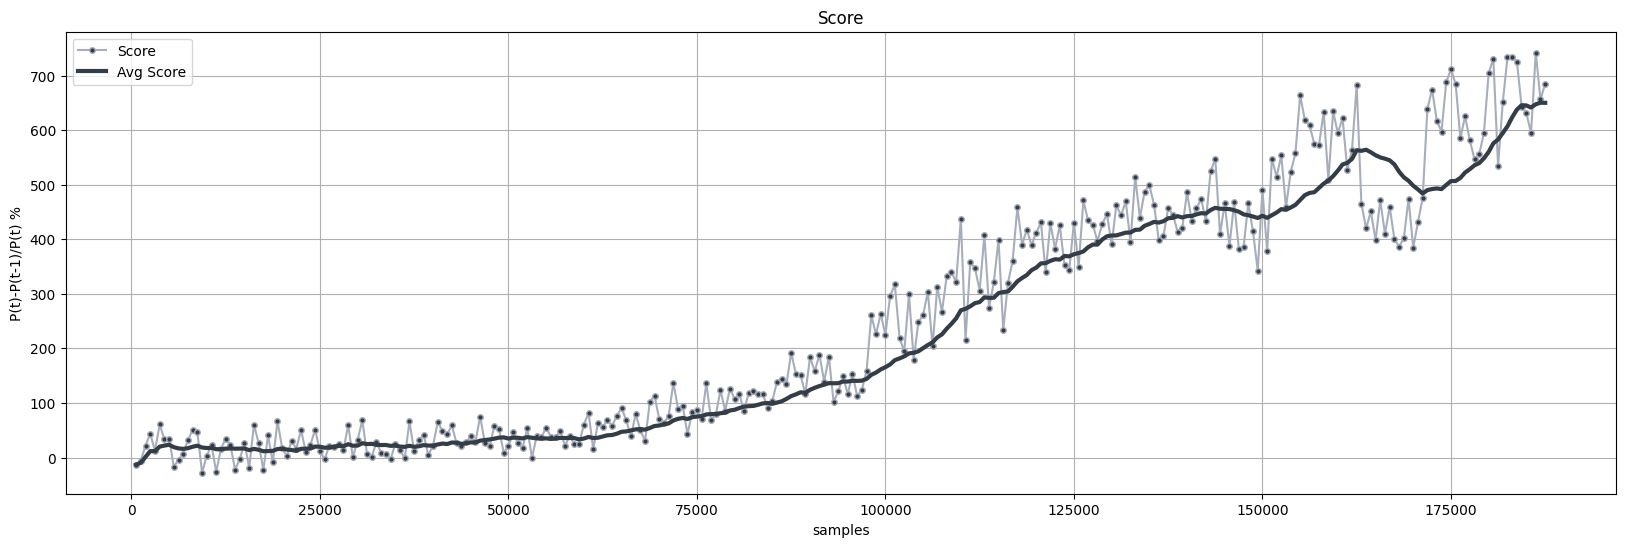

In [48]:
linear_chart_score(steps_array,scores,PATH)

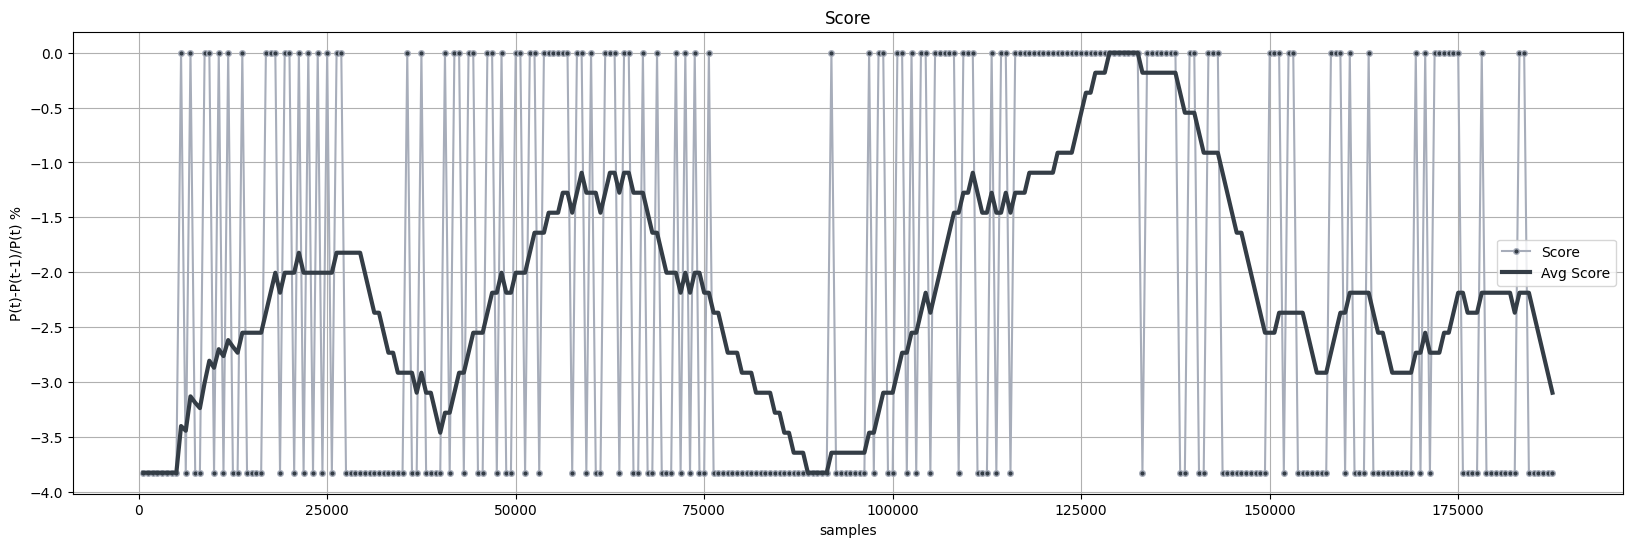

In [49]:
linear_chart_score(steps_array,scores_val,PATH)

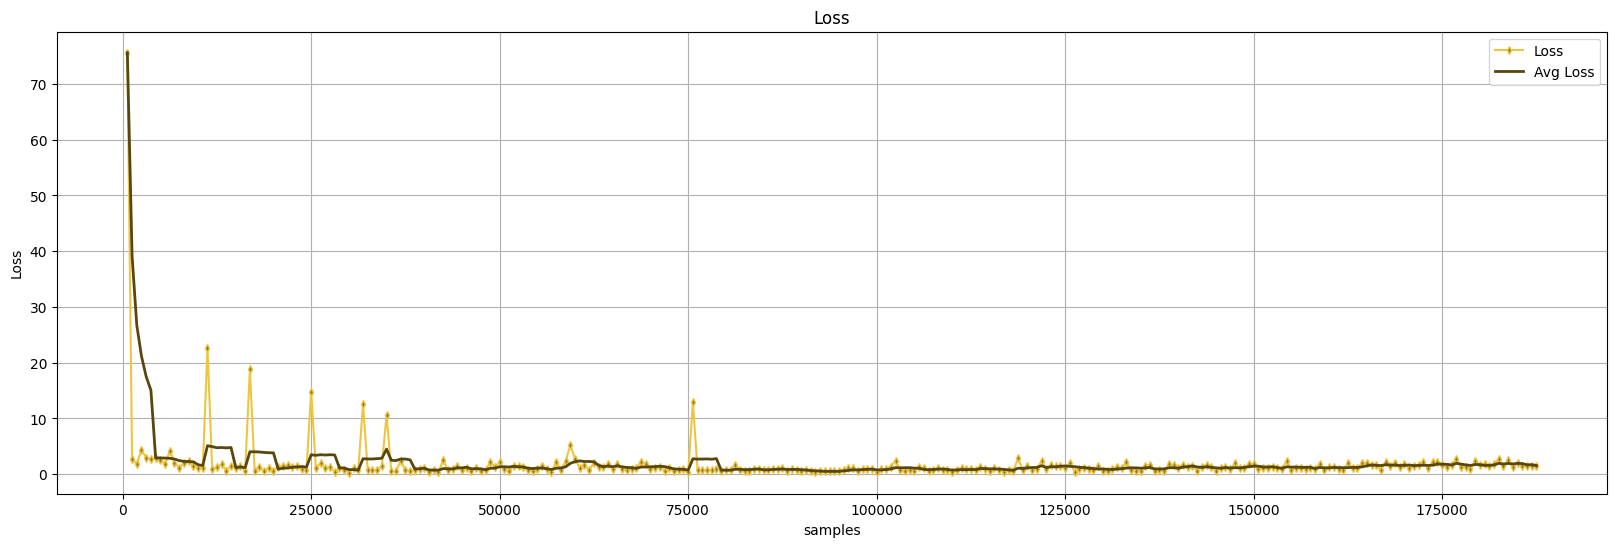

In [50]:
linear_chart_loss(steps_array,losses,PATH)

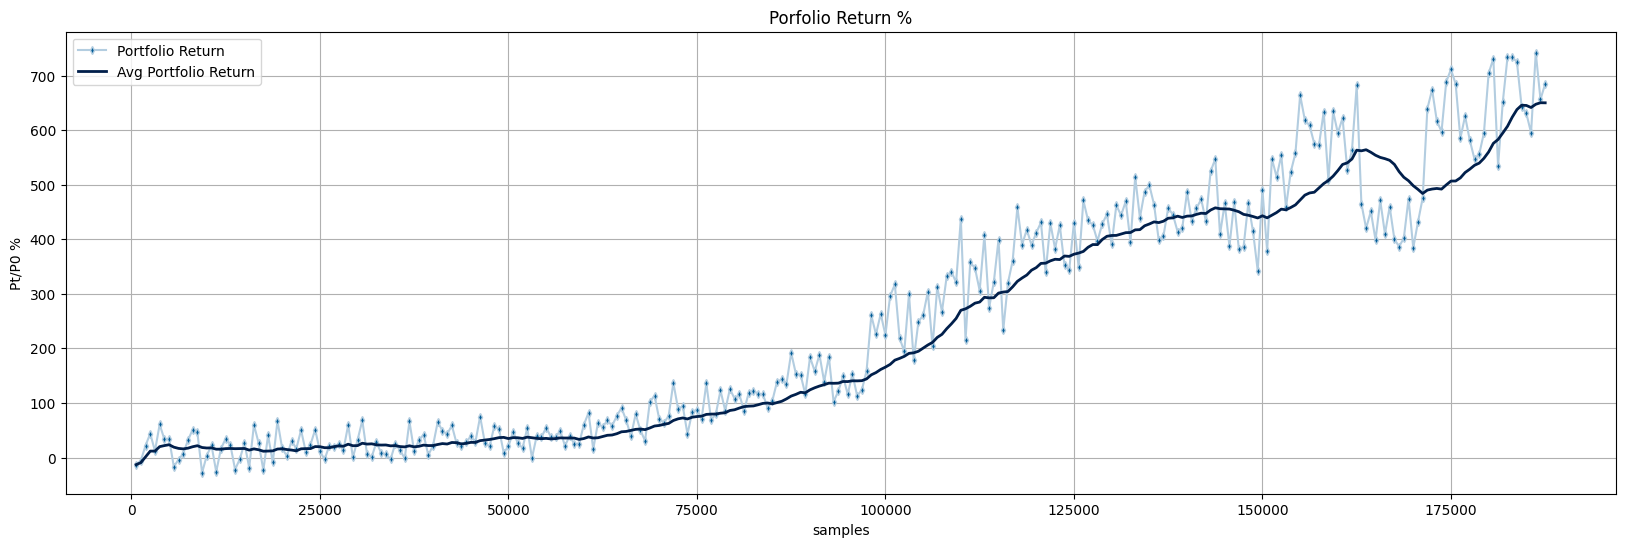

In [51]:
linear_chart_portfolio(steps_array,portfolios,PATH)

In [52]:
env.df.to_csv(f"{PATH}df_{string_folder}.csv")

In [ ]:
env.df.head(50)

In [ ]:
env_val.df.head(50)